In [1]:
#pip install pyspark
#pip install hyperopt
#pip install mlflow

# Run these on your command line, to install xgboost
# conda install -c conda-forge xgboost
# conda install -c anaconda py-xgboost
# mlflow.end_run()

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

C:\Users\hp\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## EDA

We will explore the data in this segment a little bit

In [3]:
universe=pd.read_csv('movie_universe_features.csv')
seed=pd.read_csv('seed.csv')

resp=pd.merge(seed, universe, 'left', 'User_ID')
resp['label']=1


# If we want to take ration of seed vs non seed (stratified sample), we do this:-
#ratio = 1.5 # That mean I want my non responders to be 1.5 times than responders. This is usually the case with real scenarios, like a car showroom with seed as leads generated
ratio=1.0
size=int(resp.shape[0]*ratio)
print(size)

# Balanced size of seed
non_resp=universe[~universe['User_ID'].isin(seed['User_ID'])].sample(size)
non_resp['label']=0

# Based on the size of seed, if it was less than 1k, we might had to oversample it using SMOTE

# Modelling data
modelinput = pd.concat([resp, non_resp], axis=0, ignore_index=True)

modelinput.groupby('label').count()['User_ID']

1500


label
0    1500
1    1500
Name: User_ID, dtype: int64

In [4]:
# Standardize data, dont change features
modelinput.head()

,User_ID,Feature_001,Feature_002,Feature_003,Feature_004,Feature_005,Feature_006,Feature_007,Feature_008,Feature_009,...,Feature_072,Feature_073,Feature_074,Feature_075,Feature_076,Feature_077,Feature_078,Feature_079,Feature_080,label
0,INT00092,206.243190,172.838940,202.938784,134.112398,24.740037,248.495538,192.091274,221.953195,145.304330,...,28.592187,128.804669,97.295007,72.452690,130.844721,74.890550,358.422522,120.538450,19.967594,1
1,INT07036,543.127707,90.711916,134.118140,186.000208,264.362627,204.174516,142.093918,183.523252,112.916958,...,173.366782,39.482727,150.839235,111.841791,140.807725,28.030080,363.393482,82.127047,52.022276,1
2,INT07986,80.056929,527.016395,171.400298,158.375114,276.221821,122.936893,73.610296,314.275200,54.513806,...,116.504029,155.499744,79.074381,244.758508,58.140622,307.239774,122.213837,140.591718,68.520784,1
3,INT05013,110.448341,89.248030,29.429533,242.939986,229.392574,6.347720,464.174085,18.723098,360.227617,...,51.970690,87.417379,401.220964,181.709886,139.806664,199.185706,446.593605,273.357803,75.020539,1
4,INT11913,122.470760,136.106621,191.891361,97.843022,226.060632,119.074799,211.841565,241.971746,372.741405,...,461.600598,198.747541,302.364278,169.325507,241.464305,80.877443,5.887108,68.242544,40.683640,1


In [5]:
if pd.isnull(modelinput['User_ID']).sum()==0:
    print('No missing IDs')
else:
    modelinput=modelinput[~pd.isnull(modelinput['User_ID'])]
    
modelinput.fillna(0, inplace=True)
modelinput.index=modelinput['User_ID']
modelinput.drop('User_ID', axis=1, inplace=True)
modelinput.label.count()

No missing IDs


3000

In [6]:
modelinput.head()

,Feature_001,Feature_002,Feature_003,Feature_004,Feature_005,Feature_006,Feature_007,Feature_008,Feature_009,Feature_010,...,Feature_072,Feature_073,Feature_074,Feature_075,Feature_076,Feature_077,Feature_078,Feature_079,Feature_080,label
User_ID,,,,,,,,,,,,,,,,,,,,,
INT00092,206.243190,172.838940,202.938784,134.112398,24.740037,248.495538,192.091274,221.953195,145.304330,509.897800,...,28.592187,128.804669,97.295007,72.452690,130.844721,74.890550,358.422522,120.538450,19.967594,1
INT07036,543.127707,90.711916,134.118140,186.000208,264.362627,204.174516,142.093918,183.523252,112.916958,63.945388,...,173.366782,39.482727,150.839235,111.841791,140.807725,28.030080,363.393482,82.127047,52.022276,1
INT07986,80.056929,527.016395,171.400298,158.375114,276.221821,122.936893,73.610296,314.275200,54.513806,244.663214,...,116.504029,155.499744,79.074381,244.758508,58.140622,307.239774,122.213837,140.591718,68.520784,1
INT05013,110.448341,89.248030,29.429533,242.939986,229.392574,6.347720,464.174085,18.723098,360.227617,25.471682,...,51.970690,87.417379,401.220964,181.709886,139.806664,199.185706,446.593605,273.357803,75.020539,1
INT11913,122.470760,136.106621,191.891361,97.843022,226.060632,119.074799,211.841565,241.971746,372.741405,262.806467,...,461.600598,198.747541,302.364278,169.325507,241.464305,80.877443,5.887108,68.242544,40.683640,1


In [7]:
X_train, X_test, y_train, y_test = train_test_split(modelinput.drop(['label'], axis=1), 
                                                    modelinput['label'], test_size=0.2, random_state=123)

print(X_train.shape[0], X_train.shape[1])
print(X_test.shape[0], X_test.shape[1])

print("Train seed Responders: {}; Non Responders: {}".format(y_train.sum(), y_train.count()-y_train.sum()))

scaler=StandardScaler()

scaled_train=scaler.fit_transform(X_train)
scaled_test=scaler.transform(X_test)

print(scaled_train)

2400 80
600 80
Train seed Responders: 1199; Non Responders: 1201
[[ 0.68730594 -0.55769597  1.0909763  ... -0.88063292 -1.26920991
  -0.66357889]
 [-0.89998656  2.58881991 -1.22429451 ...  0.38747316 -1.15969896
  -0.36572705]
 [ 0.94556301 -1.26598186 -1.1376411  ... -0.34540925  0.18866108
   1.10139593]
 ...
 [ 1.28161644 -0.03514195 -0.38554887 ... -0.02110052 -1.00345673
  -0.21626203]
 [ 0.52643726 -0.53766228 -0.46662515 ...  1.85796171 -0.65778717
   0.49258675]
 [-0.35049763 -0.24491445 -0.81660265 ...  1.94179599  0.32770217
   0.41412769]]


### Feature Selection happens here

In [8]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score

"""
We will be using Hyper Opt
Hyperopt uses a form of Bayesian optimization for parameter tuning that allows you to get the best parameters
for a given model. 
It can optimize a model with hundreds of parameters on a large scale.
"""

# set parameter list
n_estimators=[i for i in range(100,500, 100)]
max_depth=[i for i in range(2,13,1)]

cv = StratifiedKFold(n_splits=5)

#create random grid
rf_param = {
    'n_estimators': n_estimators,
    'max_depth': max_depth
}

# initiate model
rf_clf=RandomForestClassifier(random_state=42)

# Do a Random search for parameters
rf_random = RandomizedSearchCV(estimator=rf_clf, param_distributions=rf_param, n_iter=30, cv=cv, verbose=1, random_state=42, n_jobs=-1)

# Fit the model and show the best parameters
rf_random.fit(scaled_train, y_train)
print(rf_random.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
{'n_estimators': 300, 'max_depth': 12}


In [9]:
# get the best trial
best_rf=rf_random.best_estimator_
print(best_rf)

y_pred_train=best_rf.predict(scaled_train)
y_pred_test=best_rf.predict(scaled_test)

# Print Random Forest Model metrics
print('Train set results')
print(classification_report(y_train, y_pred_train))
print('Training AUC is', roc_auc_score(y_train, y_pred_train))
print('Train set results')
print(classification_report(y_test, y_pred_test))
print('Test AUC is', roc_auc_score(y_test, y_pred_test))

RandomForestClassifier(max_depth=12, n_estimators=300, random_state=42)
Train set results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1201
           1       1.00      1.00      1.00      1199

    accuracy                           1.00      2400
   macro avg       1.00      1.00      1.00      2400
weighted avg       1.00      1.00      1.00      2400

Training AUC is 1.0
Train set results
              precision    recall  f1-score   support

           0       0.77      0.74      0.75       299
           1       0.75      0.79      0.77       301

    accuracy                           0.76       600
   macro avg       0.76      0.76      0.76       600
weighted avg       0.76      0.76      0.76       600

Test AUC is 0.7615806842298247


Due to the type of stratified sample we choose, we are getting a good results. Lets see how much can we improve it

In [10]:
# save feature importances

feature_importances = best_rf.feature_importances_  # list
rf_imp=pd.DataFrame(feature_importances)
rf_imp=rf_imp.rename(columns={0:'Feature Importance'})


feature_names=[i for i in X_train.columns if i not in ['User_ID', 'label']]
rf_fname=pd.DataFrame(feature_names)
rf_fname=rf_fname.rename(columns={0:'Feature Name'})


rf_feature_table=pd.concat([rf_fname, rf_imp], axis=1)

In [11]:
pd.set_option("display.max_rows", None)
rf_feature_table.sort_values(by='Feature Importance', ascending=False).head(200)

,Feature Name,Feature Importance
26,Feature_027,0.020971
48,Feature_049,0.019233
16,Feature_017,0.018675
25,Feature_026,0.017596
59,Feature_060,0.016491
33,Feature_034,0.016424
68,Feature_069,0.016309
43,Feature_044,0.016161
13,Feature_014,0.015750
45,Feature_046,0.015650


<AxesSubplot: xlabel='Feature Importance', ylabel='Feature Name'>

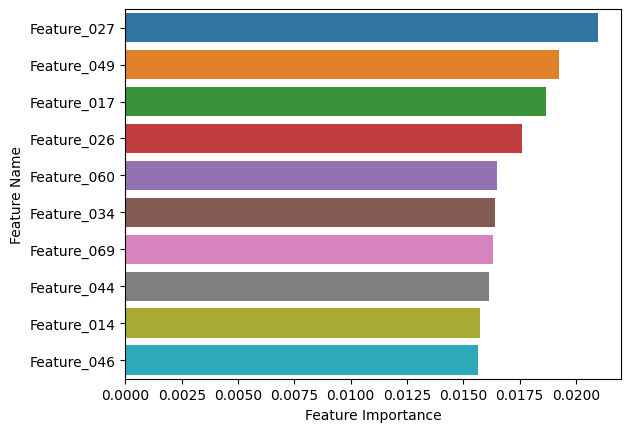

In [12]:
rf_feature_table_sorted=rf_feature_table.sort_values(by='Feature Importance', ascending=False)
sns.barplot(y=rf_feature_table_sorted['Feature Name'].iloc[:10], 
            x=rf_feature_table_sorted['Feature Importance'].iloc[:10], orient='h')

<AxesSubplot: xlabel='Cumulative Feature Importance', ylabel='Feature Name'>

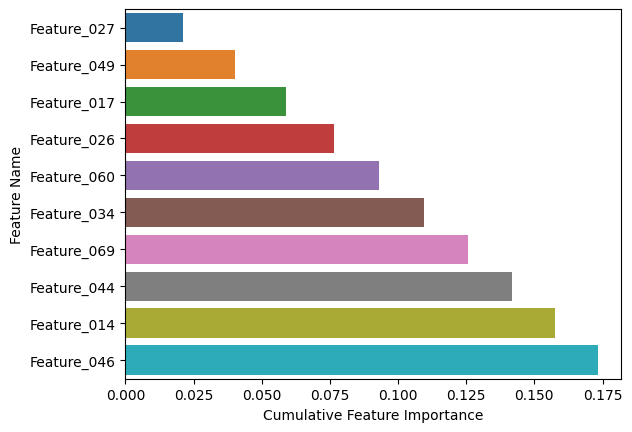

In [13]:
rf_feature_table_sorted['Cumulative Feature Importance']=rf_feature_table_sorted['Feature Importance'].cumsum()
sns.barplot(y=rf_feature_table_sorted['Feature Name'].iloc[:10], 
            x=rf_feature_table_sorted['Cumulative Feature Importance'].iloc[:10], orient='h')

In [14]:
#keep the 80% important features
print(rf_feature_table_sorted[rf_feature_table_sorted['Cumulative Feature Importance']<0.8].shape[0])
features_keep = rf_feature_table_sorted[rf_feature_table_sorted['Cumulative Feature Importance']<0.8]['Feature Name'].tolist()
features_list = [i for i in rf_feature_table['Feature Name'].tolist() if i in features_keep]
print(len(features_list))

60
60


In [15]:
# The above selected features will go for final estimator model
modelinput_gbm=modelinput[features_list+['label']]

print(modelinput_gbm.shape)
modelinput_gbm.head(5)

(3000, 61)


,Feature_001,Feature_002,Feature_003,Feature_004,Feature_006,Feature_008,Feature_009,Feature_010,Feature_011,Feature_014,...,Feature_070,Feature_071,Feature_072,Feature_073,Feature_074,Feature_077,Feature_078,Feature_079,Feature_080,label
User_ID,,,,,,,,,,,,,,,,,,,,,
INT00092,206.243190,172.838940,202.938784,134.112398,248.495538,221.953195,145.304330,509.897800,63.205423,52.576835,...,24.438563,549.558859,28.592187,128.804669,97.295007,74.890550,358.422522,120.538450,19.967594,1
INT07036,543.127707,90.711916,134.118140,186.000208,204.174516,183.523252,112.916958,63.945388,170.463188,393.809941,...,119.320365,74.288725,173.366782,39.482727,150.839235,28.030080,363.393482,82.127047,52.022276,1
INT07986,80.056929,527.016395,171.400298,158.375114,122.936893,314.275200,54.513806,244.663214,28.806132,265.630722,...,18.915626,364.603934,116.504029,155.499744,79.074381,307.239774,122.213837,140.591718,68.520784,1
INT05013,110.448341,89.248030,29.429533,242.939986,6.347720,18.723098,360.227617,25.471682,2.242972,403.971151,...,183.297648,360.586374,51.970690,87.417379,401.220964,199.185706,446.593605,273.357803,75.020539,1
INT11913,122.470760,136.106621,191.891361,97.843022,119.074799,241.971746,372.741405,262.806467,161.559277,59.645438,...,13.673104,147.253233,461.600598,198.747541,302.364278,80.877443,5.887108,68.242544,40.683640,1


In [16]:
X_train, X_test, y_train, y_test = train_test_split(modelinput_gbm.drop(['label'], axis=1), 
                                                    modelinput_gbm['label'], test_size=0.2, random_state=1233)

print(X_train.shape[0], X_train.shape[1])
print(X_test.shape[0], X_test.shape[1])

print("Train seed Responders: {}; Non Responders: {}".format(y_train.sum(), y_train.count()-y_train.sum()))

scaler=StandardScaler()

scaled_train=scaler.fit_transform(X_train)
scaled_test=scaler.transform(X_test)

2400 60
600 60
Train seed Responders: 1202; Non Responders: 1198


In [17]:
# Save the scaler model, as well as the feature list
import pickle

with open("scalerModelObj.pkl", "wb") as f:
    pickle.dump(scaler, f)
    
with open("final_feature_list.pkl","wb") as f:
    pickle.dump(features_list, f)

In [18]:
# mlflow.end_run()

In [19]:
#define model space
# Note: - keep running 'mlflow ui' command in anaconda prompt, for mlflow to work 
from sklearn.model_selection import cross_val_score
from hyperopt import fmin, tpe, hp, SparkTrials, STATUS_OK, Trials
import pyspark
from sklearn.metrics import accuracy_score
import mlflow
from xgboost import XGBClassifier
from builtins import round, max, min, int

mlflow.autolog()
# set tracking uri, where mlflow saves runs
#mlflow.set_tracking_uri("file:///C:/Users/Ayush/Desktop/Books/Python%20with%20machine%20learning%20and%20data%20science%20bootcamp/mlflow")

# create an experiment
#experiment_id=mlflow.create_experiment("lal_gbt_train_exp1")
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("lal_gbt_train_exp1")
experiment_id=dict(mlflow.get_experiment_by_name("lal_gbt_train_exp1"))["experiment_id"]


feature_space_gbt = hp.choice('classifier_type',[
                          {
                                  'type':'gbt',
                                  'max_depth':hp.quniform('max_depth', 2, 13, 1),
                                  'n_estimators':hp.quniform('n_estimators', 50, 500, 50),
                                  'learning_rate':hp.quniform('learning_rate', 0.05, 0.95, 0.05),
                                  'subsample':hp.quniform('subsample', 0.1, 1, 0.1)
                          },

])

feature_space_xgb = hp.choice('classifier_type',[
                          {
                                  'type':'xgboost',
                                  'max_depth':hp.quniform('max_depth', 10, 30, 1),
                                  'n_estimators':hp.quniform('n_estimators', 1, 151, 10),
                                  'learning_rate':hp.quniform('learning_rate', 0.01, 0.99, 0.01),
                                  'subsample':hp.quniform('subsample', 0.2, 1, 0.01)
                          },

])

def minmization_fn_gbt(params):
    classifier_type=params['type']
    del params['type']
    if classifier_type=='gbt':
        # Initialise GBT
        clf=GradientBoostingClassifier(n_estimators=int(params['n_estimators']),learning_rate=params['learning_rate'],
                                       max_depth=int(params['max_depth']), subsample=params['subsample'])
    else:
        return 0
    
    with mlflow.start_run(nested=True):
        mlflow.log_param("learning_rate", params['learning_rate'])
        mlflow.log_param("n_estimators", params['learning_rate'])
        mlflow.log_param("max_depth", params['max_depth'])
        mlflow.log_param("subsample", params['subsample'])
    
    gbt_model=clf.fit(scaled_train, y_train)
    y_train_pred = gbt_model.predict(scaled_train)
    y_test_pred = gbt_model.predict(scaled_test)
    train_auc=roc_auc_score(y_train, y_train_pred)
    test_auc=roc_auc_score(y_test, y_test_pred)
    
    print("Training AUC is: %f"% (train_auc))
    print("Test AUC is: %f"% (test_auc))
    
    with mlflow.start_run(nested=True): 
        mlflow.log_metric("test_auc", test_auc)
        mlflow.log_metric("train_auc", train_auc)
        #log models
        mlflow.sklearn.log_model(clf, 'model')
    
    # Since fmin will minimize the objective loss, this function should return negative accuracy
    return {'loss':-test_auc/(1+train_auc-test_auc), 'status':STATUS_OK, 'Train_AUC':train_auc, 'Test_AUC':test_auc,
            'important_features':gbt_model.feature_importances_,
           'model':gbt_model}

def minmization_fn_xgb(params):
    classifier_type=params['type']
    del params['type']
    if classifier_type=='xgboost':
        # Initialise GBT
        clf=XGBClassifier(n_estimators=int(params['n_estimators']),learning_rate=params['learning_rate'],
                                       max_depth=int(params['max_depth']), subsample=params['subsample'])
    else:
        return 0
    
    with mlflow.start_run(nested=True):
        mlflow.log_param("learning_rate", params['learning_rate'])
        mlflow.log_param("n_estimators", params['learning_rate'])
        mlflow.log_param("max_depth", params['max_depth'])
        mlflow.log_param("subsample", params['subsample'])
    
    xgb_model=clf.fit(scaled_train, y_train)
    y_train_pred = xgb_model.predict(scaled_train)
    y_test_pred = xgb_model.predict(scaled_test)
    train_auc=roc_auc_score(y_train, y_train_pred)
    test_auc=roc_auc_score(y_test, y_test_pred)
    test_acc=accuracy_score(y_test, y_test_pred)
    train_acc=accuracy_score(y_train, y_train_pred)
    
    print("Training AUC is: %f"% (train_auc))
    print("Test AUC is: %f"% (test_auc))
    
    print("Training accuracy is: %f"% (train_acc))
    print("Test accuracy is: %f"% (test_acc))
    
    with mlflow.start_run(nested=True):
        mlflow.log_metric("test_auc", test_auc)
        mlflow.log_metric("train_auc", train_auc)
    loss=-test_auc/(1+train_auc-test_auc)
    
    # Since fmin will minimize the objective loss, this function should return negative accuracy
    return {'loss':loss, 'status':STATUS_OK, 'Train_AUC':train_auc, 'Test_AUC':test_auc,
            'important_features':xgb_model.feature_importances_,
           'model':xgb_model}


2024/06/14 12:54:39 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2024/06/14 12:54:40 WARNING mlflow.tracking.fluent: Exception raised while enabling autologging for sklearn: 'NoneType' object has no attribute 'split'
2024/06/14 12:54:40 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2024/06/14 12:54:40 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2024/06/14 12:54:40 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.


In [20]:
trials = Trials()
mlflow.end_run()
best=None

mlflow.end_run()

# Launch the search
with mlflow.start_run(experiment_id=experiment_id):
    with mlflow.start_run(nested=True):
        #log run tags 
        mlflow.set_tag('some_tag', 'Parallelized HyperOpt')
    best = fmin(
            fn=minmization_fn_xgb,
            space=feature_space_xgb,
            algo=tpe.suggest,
            trials=trials,
            max_evals=30
    )
        


  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]

2024/06/14 12:54:48 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\hp\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:54:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."

2024/06/14 12:55:00 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\hp\anaconda3\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils."



Training AUC is: 1.000000                                                                                              
Test AUC is: 0.753411                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.753333                                                                                             
  3%|█▌                                              | 1/30 [00:17<08:26, 17.48s/trial, best loss: -0.6043783648875103]

2024/06/14 12:56:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID d72840d7badb44659f30b340d1214571. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError(\'too many 500 error responses\'))")]')]

2024/06/14 12:56:01 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\hp\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:56:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, ple

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.766701                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.766667                                                                                             
  7%|███▏                                            | 2/30 [01:28<22:50, 48.96s/trial, best loss: -0.6216664264091107]

2024/06/14 12:57:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID d72840d7badb44659f30b340d1214571. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError(\'too many 500 error responses\'))")]')]

2024/06/14 12:57:12 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\hp\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:57:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, ple

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.771823                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.771667                                                                                             
 10%|████▊                                           | 3/30 [02:38<26:16, 58.37s/trial, best loss: -0.6284300332033548]

2024/06/14 12:58:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID d72840d7badb44659f30b340d1214571. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError(\'too many 500 error responses\'))")]')]

2024/06/14 12:58:21 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\hp\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:58:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, ple

Training AUC is: 0.985824                                                                                              
Test AUC is: 0.689897                                                                                                  
Training accuracy is: 0.985833                                                                                         
Test accuracy is: 0.690000                                                                                             
 13%|██████▍                                         | 4/30 [03:47<27:13, 62.82s/trial, best loss: -0.6284300332033548]

2024/06/14 12:59:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID d72840d7badb44659f30b340d1214571. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError(\'too many 500 error responses\'))")]')]

2024/06/14 12:59:31 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\hp\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:59:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, ple

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.785113                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.785000                                                                                             
 17%|████████                                        | 5/30 [04:57<27:11, 65.26s/trial, best loss: -0.6462431975122332]

2024/06/14 13:00:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID d72840d7badb44659f30b340d1214571. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError(\'too many 500 error responses\'))")]')]

2024/06/14 13:00:41 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\hp\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:00:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, ple

Training AUC is: 0.999167                                                                                              
Test AUC is: 0.706698                                                                                                  
Training accuracy is: 0.999167                                                                                         
Test accuracy is: 0.706667                                                                                             
 20%|█████████▌                                      | 6/30 [06:06<26:40, 66.67s/trial, best loss: -0.6462431975122332]

2024/06/14 13:01:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID d72840d7badb44659f30b340d1214571. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError(\'too many 500 error responses\'))")]')]

2024/06/14 13:01:50 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\hp\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:01:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, ple

Training AUC is: 0.910829                                                                                              
Test AUC is: 0.633206                                                                                                  
Training accuracy is: 0.910833                                                                                         
Test accuracy is: 0.633333                                                                                             
 23%|███████████▏                                    | 7/30 [07:23<26:46, 69.84s/trial, best loss: -0.6462431975122332]

2024/06/14 13:03:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID d72840d7badb44659f30b340d1214571. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError(\'too many 500 error responses\'))")]')]

2024/06/14 13:03:08 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\hp\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:03:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, ple

Training AUC is: 0.972078                                                                                              
Test AUC is: 0.698331                                                                                                  
Training accuracy is: 0.972083                                                                                         
Test accuracy is: 0.698333                                                                                             
 27%|████████████▊                                   | 8/30 [08:37<26:05, 71.18s/trial, best loss: -0.6462431975122332]

2024/06/14 13:04:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID d72840d7badb44659f30b340d1214571. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError(\'too many 500 error responses\'))")]')]

2024/06/14 13:04:21 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\hp\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:04:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, ple

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.778446                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.778333                                                                                             
 30%|██████████████▍                                 | 9/30 [09:46<24:41, 70.56s/trial, best loss: -0.6462431975122332]

2024/06/14 13:05:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID d72840d7badb44659f30b340d1214571. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError(\'too many 500 error responses\'))")]')]

2024/06/14 13:05:30 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\hp\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:05:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, ple

Training AUC is: 0.998749                                                                                              
Test AUC is: 0.711576                                                                                                  
Training accuracy is: 0.998750                                                                                         
Test accuracy is: 0.711667                                                                                             
 33%|███████████████▋                               | 10/30 [10:57<23:32, 70.61s/trial, best loss: -0.6462431975122332]

2024/06/14 13:06:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID d72840d7badb44659f30b340d1214571. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError(\'too many 500 error responses\'))")]')]

2024/06/14 13:06:40 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\hp\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:06:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, ple

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.781690                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.781667                                                                                             
 37%|█████████████████▏                             | 11/30 [12:09<22:31, 71.14s/trial, best loss: -0.6462431975122332]

2024/06/14 13:07:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID d72840d7badb44659f30b340d1214571. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError(\'too many 500 error responses\'))")]')]

2024/06/14 13:07:53 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\hp\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:07:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, ple

Training AUC is: 0.974571                                                                                              
Test AUC is: 0.781713                                                                                                  
Training accuracy is: 0.974583                                                                                         
Test accuracy is: 0.781667                                                                                             
 40%|██████████████████▊                            | 12/30 [13:39<23:06, 77.04s/trial, best loss: -0.6553268761128193]

2024/06/14 13:09:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID d72840d7badb44659f30b340d1214571. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError(\'too many 500 error responses\'))")]')]

2024/06/14 13:09:24 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\hp\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:09:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, ple

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.775090                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.775000                                                                                             
 43%|████████████████████▎                          | 13/30 [15:01<22:14, 78.52s/trial, best loss: -0.6553268761128193]

2024/06/14 13:10:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID d72840d7badb44659f30b340d1214571. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError(\'too many 500 error responses\'))")]')]

2024/06/14 13:10:45 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\hp\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:10:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, ple

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.755156                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.755000                                                                                             
 47%|█████████████████████▉                         | 14/30 [16:19<20:53, 78.37s/trial, best loss: -0.6553268761128193]

2024/06/14 13:12:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID d72840d7badb44659f30b340d1214571. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError(\'too many 500 error responses\'))")]')]

2024/06/14 13:12:04 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\hp\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:12:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, ple

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.753389                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.753333                                                                                             
 50%|███████████████████████▌                       | 15/30 [17:31<19:05, 76.34s/trial, best loss: -0.6553268761128193]

2024/06/14 13:13:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID d72840d7badb44659f30b340d1214571. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError(\'too many 500 error responses\'))")]')]

2024/06/14 13:13:15 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\hp\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:13:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, ple

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.696787                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.696667                                                                                             
 53%|█████████████████████████                      | 16/30 [18:35<16:58, 72.73s/trial, best loss: -0.6553268761128193]

2024/06/14 13:14:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID d72840d7badb44659f30b340d1214571. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError(\'too many 500 error responses\'))")]')]

2024/06/14 13:14:19 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\hp\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:14:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, ple

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.715243                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.715000                                                                                             
 57%|██████████████████████████▋                    | 17/30 [19:37<15:03, 69.49s/trial, best loss: -0.6553268761128193]

2024/06/14 13:15:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID d72840d7badb44659f30b340d1214571. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError(\'too many 500 error responses\'))")]')]

2024/06/14 13:15:21 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\hp\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:15:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, ple

Training AUC is: 0.975405                                                                                              
Test AUC is: 0.686497                                                                                                  
Training accuracy is: 0.975417                                                                                         
Test accuracy is: 0.686667                                                                                             
 60%|████████████████████████████▏                  | 18/30 [20:39<13:27, 67.27s/trial, best loss: -0.6553268761128193]

2024/06/14 13:16:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID d72840d7badb44659f30b340d1214571. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError(\'too many 500 error responses\'))")]')]

2024/06/14 13:16:23 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\hp\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:16:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, ple

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.738444                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.738333                                                                                             
 63%|█████████████████████████████▊                 | 19/30 [21:40<11:59, 65.39s/trial, best loss: -0.6553268761128193]

2024/06/14 13:17:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID d72840d7badb44659f30b340d1214571. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError(\'too many 500 error responses\'))")]')]

2024/06/14 13:17:24 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\hp\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:17:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, ple

Training AUC is: 0.997499                                                                                              
Test AUC is: 0.745000                                                                                                  
Training accuracy is: 0.997500                                                                                         
Test accuracy is: 0.745000                                                                                             
 67%|███████████████████████████████▎               | 20/30 [22:43<10:44, 64.43s/trial, best loss: -0.6553268761128193]

2024/06/14 13:18:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID d72840d7badb44659f30b340d1214571. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError(\'too many 500 error responses\'))")]')]

2024/06/14 13:18:26 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\hp\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:18:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, ple

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.788535                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.788333                                                                                             
 70%|████████████████████████████████▉              | 21/30 [23:48<09:42, 64.68s/trial, best loss: -0.6553268761128193]

2024/06/14 13:19:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID d72840d7badb44659f30b340d1214571. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError(\'too many 500 error responses\'))")]')]

2024/06/14 13:19:32 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\hp\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:19:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, ple

Training AUC is: 0.999167                                                                                              
Test AUC is: 0.795135                                                                                                  
Training accuracy is: 0.999167                                                                                         
Test accuracy is: 0.795000                                                                                             
 73%|██████████████████████████████████▍            | 22/30 [25:01<08:57, 67.21s/trial, best loss: -0.6603942296485936]

2024/06/14 13:20:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID d72840d7badb44659f30b340d1214571. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError(\'too many 500 error responses\'))")]')]

2024/06/14 13:20:45 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\hp\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:20:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, ple

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.783524                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.783333                                                                                             
 77%|████████████████████████████████████           | 23/30 [26:13<08:00, 68.67s/trial, best loss: -0.6603942296485936]

2024/06/14 13:21:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID d72840d7badb44659f30b340d1214571. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError(\'too many 500 error responses\'))")]')]

2024/06/14 13:21:57 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\hp\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:21:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, ple

Training AUC is: 0.973755                                                                                              
Test AUC is: 0.728266                                                                                                  
Training accuracy is: 0.973750                                                                                         
Test accuracy is: 0.728333                                                                                             
 80%|█████████████████████████████████████▌         | 24/30 [27:24<06:56, 69.42s/trial, best loss: -0.6603942296485936]

2024/06/14 13:23:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID d72840d7badb44659f30b340d1214571. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError(\'too many 500 error responses\'))")]')]

2024/06/14 13:23:08 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\hp\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:23:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, ple

Training AUC is: 0.996247                                                                                              
Test AUC is: 0.796969                                                                                                  
Training accuracy is: 0.996250                                                                                         
Test accuracy is: 0.796667                                                                                             
 83%|███████████████████████████████████████▏       | 25/30 [28:32<05:45, 69.04s/trial, best loss: -0.6645405915394991]

2024/06/14 13:24:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID d72840d7badb44659f30b340d1214571. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError(\'too many 500 error responses\'))")]')]

2024/06/14 13:24:16 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\hp\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:24:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, ple

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.719988                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.720000                                                                                             
 87%|████████████████████████████████████████▋      | 26/30 [29:41<04:36, 69.07s/trial, best loss: -0.6645405915394991]

2024/06/14 13:25:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID d72840d7badb44659f30b340d1214571. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError(\'too many 500 error responses\'))")]')]

2024/06/14 13:25:25 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\hp\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:25:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, ple

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.699987                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.700000                                                                                             
 90%|██████████████████████████████████████████▎    | 27/30 [30:50<03:26, 68.98s/trial, best loss: -0.6645405915394991]

2024/06/14 13:26:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID d72840d7badb44659f30b340d1214571. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError(\'too many 500 error responses\'))")]')]

2024/06/14 13:26:34 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\hp\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:26:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, ple

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.806836                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.806667                                                                                             
 93%|███████████████████████████████████████████▊   | 28/30 [31:59<02:17, 68.94s/trial, best loss: -0.6762153101136152]

2024/06/14 13:27:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID d72840d7badb44659f30b340d1214571. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError(\'too many 500 error responses\'))")]')]

2024/06/14 13:27:43 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\hp\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:27:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, ple

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.745044                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.745000                                                                                             
 97%|█████████████████████████████████████████████▍ | 29/30 [33:09<01:09, 69.23s/trial, best loss: -0.6762153101136152]

2024/06/14 13:28:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID d72840d7badb44659f30b340d1214571. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError(\'too many 500 error responses\'))")]')]

2024/06/14 13:28:53 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\hp\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:28:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, ple

Training AUC is: 0.999167                                                                                              
Test AUC is: 0.770079                                                                                                  
Training accuracy is: 0.999167                                                                                         
Test accuracy is: 0.770000                                                                                             
100%|███████████████████████████████████████████████| 30/30 [34:18<00:00, 68.62s/trial, best loss: -0.6762153101136152]


In [21]:
print("Best Run: {}".format(best))

Best Run: {'classifier_type': 0, 'learning_rate': 0.13, 'max_depth': 28.0, 'n_estimators': 140.0, 'subsample': 0.49}


In [22]:
best_model_gbt = trials.best_trial['result']['model']
print(best_model_gbt)
print("Best Model Metrics and Parameters are: {}".format(best))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.13, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=28, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=140, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
Best Model Metrics and Parameters are: {'classifier_type': 0, 'learning_rate': 0.13, 'max_depth': 28.0, 'n_estimators': 140.0, 'subsample': 0.49}


In [23]:
# Save gbt model
with open("gbtModel.pkl", "wb") as f:
    pickle.dump(best_model_gbt, f)

In [24]:
# Model metrics
def clf_evaluation(model, X_actual, y_actual):
    y_pred=model.predict(X_actual)
    
    # Print Random Forest Model metrics
    print(classification_report(y_actual, y_pred))
    print('AUC score is', roc_auc_score(y_actual, y_pred))

print("\t","="*12+" Training Set"+"="*12)
clf_evaluation(best_model_gbt, scaled_train, y_train)
print("\t","="*12+" Test Set"+"="*12)
clf_evaluation(best_model_gbt, scaled_test, y_test)

	 ============ Training Set============
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1198
           1       1.00      1.00      1.00      1202

    accuracy                           1.00      2400
   macro avg       1.00      1.00      1.00      2400
weighted avg       1.00      1.00      1.00      2400

AUC score is 1.0
	 ============ Test Set============
              precision    recall  f1-score   support

           0       0.83      0.78      0.80       302
           1       0.79      0.83      0.81       298

    accuracy                           0.81       600
   macro avg       0.81      0.81      0.81       600
weighted avg       0.81      0.81      0.81       600

AUC score is 0.8068358593715277


In [25]:
#get features
imp_features = best_model_gbt.feature_importances_
gbt_feature_imp = pd.DataFrame(imp_features)

gbt_feature_imp=gbt_feature_imp.rename(columns={0:'Feature Importance'})
gbt_feature_names=pd.DataFrame(features_list)
gbt_feature_names=gbt_feature_names.rename(columns={0:'Feature Name'})
gbt_feature_importance=pd.concat([gbt_feature_names, gbt_feature_imp], axis=1)
gbt_feature_importance=gbt_feature_importance.sort_values(by='Feature Importance', ascending=False)

Since the accuracy of gbt is not so good, we will retrain it again using xgboost and lesser features

In [28]:
top_features_gbt=gbt_feature_importance['Feature Name'].tolist()
new_features_list=[f for f in features_list if f in top_features_gbt]

modelinput_xgb = modelinput[new_features_list+['label']]
print(modelinput_xgb.shape)

X_train, X_test, y_train, y_test = train_test_split(modelinput_xgb.drop(['label'], axis=1), 
                                                    modelinput_xgb['label'], test_size=0.3, random_state=1233)

print(X_train.shape[0], X_train.shape[1])
print(X_test.shape[0], X_test.shape[1])

print("Train seed Responders: {}; Non Responders: {}".format(y_train.sum(), y_train.count()-y_train.sum()))

scaler=MinMaxScaler()

scaled_train=scaler.fit_transform(X_train)
scaled_test=scaler.transform(X_test)

modelinput_xgb.head()

(3000, 61)
2100 60
900 60
Train seed Responders: 1056; Non Responders: 1044


,Feature_001,Feature_002,Feature_003,Feature_004,Feature_006,Feature_008,Feature_009,Feature_010,Feature_011,Feature_014,...,Feature_070,Feature_071,Feature_072,Feature_073,Feature_074,Feature_077,Feature_078,Feature_079,Feature_080,label
User_ID,,,,,,,,,,,,,,,,,,,,,
INT00092,206.243190,172.838940,202.938784,134.112398,248.495538,221.953195,145.304330,509.897800,63.205423,52.576835,...,24.438563,549.558859,28.592187,128.804669,97.295007,74.890550,358.422522,120.538450,19.967594,1
INT07036,543.127707,90.711916,134.118140,186.000208,204.174516,183.523252,112.916958,63.945388,170.463188,393.809941,...,119.320365,74.288725,173.366782,39.482727,150.839235,28.030080,363.393482,82.127047,52.022276,1
INT07986,80.056929,527.016395,171.400298,158.375114,122.936893,314.275200,54.513806,244.663214,28.806132,265.630722,...,18.915626,364.603934,116.504029,155.499744,79.074381,307.239774,122.213837,140.591718,68.520784,1
INT05013,110.448341,89.248030,29.429533,242.939986,6.347720,18.723098,360.227617,25.471682,2.242972,403.971151,...,183.297648,360.586374,51.970690,87.417379,401.220964,199.185706,446.593605,273.357803,75.020539,1
INT11913,122.470760,136.106621,191.891361,97.843022,119.074799,241.971746,372.741405,262.806467,161.559277,59.645438,...,13.673104,147.253233,461.600598,198.747541,302.364278,80.877443,5.887108,68.242544,40.683640,1


In [29]:
trials = Trials()
mlflow.end_run()
best=None

mlflow.end_run()

# Launch the search
with mlflow.start_run(experiment_id=experiment_id):
    with mlflow.start_run(nested=True):
        #log run tags 
        mlflow.set_tag('some_tag', 'Parallelized HyperOpt')
    best = fmin(
            fn=minmization_fn_xgb,
            space=feature_space_xgb,
            algo=tpe.suggest,
            trials=trials,
            max_evals=120
    )
        
print("Best Run: {}".format(best))

  0%|                                                                          | 0/120 [00:00<?, ?trial/s, best loss=?]

2024/06/14 13:36:44 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\hp\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:36:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



Training AUC is: 1.000000                                                                                              
Test AUC is: 0.745762                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.745556                                                                                             
  1%|▍                                               | 1/120 [00:11<22:08, 11.16s/trial, best loss: -0.594593956005009]

2024/06/14 13:37:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID bf8469936c724fcc9e268ced1704eefd. Failed operations: [MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError(\'too many 500 error responses\'))")]')]

2024/06/14 13:37:53 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\hp\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:37:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, ple

Training AUC is: 1.000000                                                                                              
Test AUC is: 0.753467                                                                                                  
Training accuracy is: 1.000000                                                                                         
Test accuracy is: 0.753333                                                                                             
  2%|▊                                            | 2/120 [01:21<1:30:31, 46.03s/trial, best loss: -0.6044504671564084]

2024/06/14 13:38:04 ERROR mlflow.xgboost: Failed to log feature importance plot. XGBoost autologging will ignore the failure and continue. Exception: 
Traceback (most recent call last):
  File "C:\Users\hp\anaconda3\Lib\site-packages\mlflow\xgboost\__init__.py", line 680, in train_impl
    features, importance = zip(*imp.items())
    ^^^^^^^^^^^^^^^^^^^^
ValueError: not enough values to unpack (expected 2, got 0)



  2%|▊                                            | 2/120 [02:22<2:20:00, 71.19s/trial, best loss: -0.6044504671564084]


KeyboardInterrupt: 

In [ ]:
best_model_xgb = trials.best_trial['result']['model']
print(best_model_xgb)
print("Best Model Metrics and Parameters are: {}".format(best))

# Save xgb model
with open("xgbModel.pkl", "wb") as f:
    pickle.dump(best_model_xgb, f)

# Save feature list for xgb
with open("xgb_feature_list", "wb") as f:
    pickle.dump(new_features_list, f)
    
# Save scaler object for the above list
with open("scalerModelObj.pkl", "wb") as f:
    pickle.dump(scaler, f)

# Evaluation metrics
print("\t","="*12+" Training Set"+"="*12)
clf_evaluation(best_model_xgb, scaled_train, y_train)
print("\t","="*12+" Test Set"+"="*12)
clf_evaluation(best_model_xgb, scaled_test, y_test)

In [ ]:
#get features
imp_features = best_model_xgb.feature_importances_
xgb_feature_imp = pd.DataFrame(imp_features)

xgb_feature_imp=xgb_feature_imp.rename(columns={0:'Feature Importance'})
xgb_feature_names=pd.DataFrame(new_features_list)
xgb_feature_names=xgb_feature_names.rename(columns={0:'Feature Name'})
xgb_feature_importance=pd.concat([xgb_feature_names, xgb_feature_imp], axis=1)
xgb_feature_importance=xgb_feature_importance.sort_values(by='Feature Importance', ascending=False)
print(len(new_features_list))

In [ ]:
f,ax = plt.subplots(figsize=(6,10))

sns.set_color_codes("pastel")
sns.barplot(x="Feature Importance", y="Feature Name", data=xgb_feature_importance, orient="h", color="b")

In [ ]:
pd.set_option("display.max_rows", None)
xgb_feature_importance.head()

In [ ]:
xgb_feature_importance.to_excel('feature_importance.xlsx')
#END